In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from torchvision import transforms
from torch.nn.parallel import DistributedDataParallel as DDP

from contrastive_learning.tests.test_model import get_closest_embeddings, save_all_embeddings, load_encoder
from contrastive_learning.models.pretrained_models import resnet18
from contrastive_learning.datasets.dataset import Dataset, get_dataloaders



/home/irmak/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29503"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [6]:
# Set the device and out_dir
device = torch.device('cuda:0')
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.06/resnet18_mlp'
encoder_path = os.path.join(out_dir, 'models/encoder.pt')

# Load the encoder
encoder = load_encoder(device, encoder_path, encoder_type='resnet18')


In [7]:
# Get the test dataloader and pass all observations to get save embeddings
cfg = OmegaConf.load('/home/irmak/Workspace/DAWGE/contrastive_learning/configs/train.yaml')

train_loader, test_loader, train_dset, test_dset = get_dataloaders(cfg)
len_dset = len(train_dset)
z_dim = cfg.z_dim 

len(train_dset): 1508
len(data_loader): 95, len_dset: 1508


In [8]:
save_all_embeddings(
    device = device,
    len_dset = len_dset, 
    z_dim = z_dim, 
    encoder = encoder,
    train_loader = train_loader, # TODO: change this parameter's name
    out_dir = out_dir
)


100%|██████████| 95/95 [00:13<00:00,  7.26it/s]


In [15]:
# Get random images from test loader, plot them with matplotlib and find the closest KNNs
inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                    std = [ 1., 1., 1. ]),
                                ])
batch = next(iter(test_loader))
obs, _, _ = [b.to(device) for b in batch]
obs = inv_trans(obs)


# Create matplotlib plots and figure
bs = obs.shape[0] 
act_obs = obs.permute(0,2,3,1).cpu() # actual observations ready to plot

data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data'
dataset = Dataset(data_dir=data_dir, frame_interval=cfg.frame_interval)

# Get the test observations in the test embeddings
k = 5
test_obs_idx = np.zeros((bs, k))
for i in range(bs):
    curr_obs = obs[i:i+1] if i < bs-1 else obs[i:]
    act_obs_id = get_closest_embeddings(
        out_dir = out_dir, 
        encoder = encoder,
        obs = curr_obs,
        k = k
    )
    test_obs_idx[i] = act_obs_id

# Get actual observations
test_obs = np.zeros((bs, k, act_obs.shape[1], act_obs.shape[2], act_obs.shape[3]))
print('test_obs.shape: {}'.format(test_obs.shape))
for i in range(bs):
    for j,kth_index in enumerate(test_obs_idx[i]):
        curr_obs, _, _ = dataset.getitem(int(kth_index))
        curr_obs = inv_trans(curr_obs)
        test_obs[i,j] = curr_obs.permute(1,2,0)


obs.shape: torch.Size([16, 3, 480, 480])
obs.shape: torch.Size([16, 3, 480, 480])
act_obs.shape: torch.Size([16, 480, 480, 3])
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
test_obs.shape: (16, 5, 480, 480, 3)


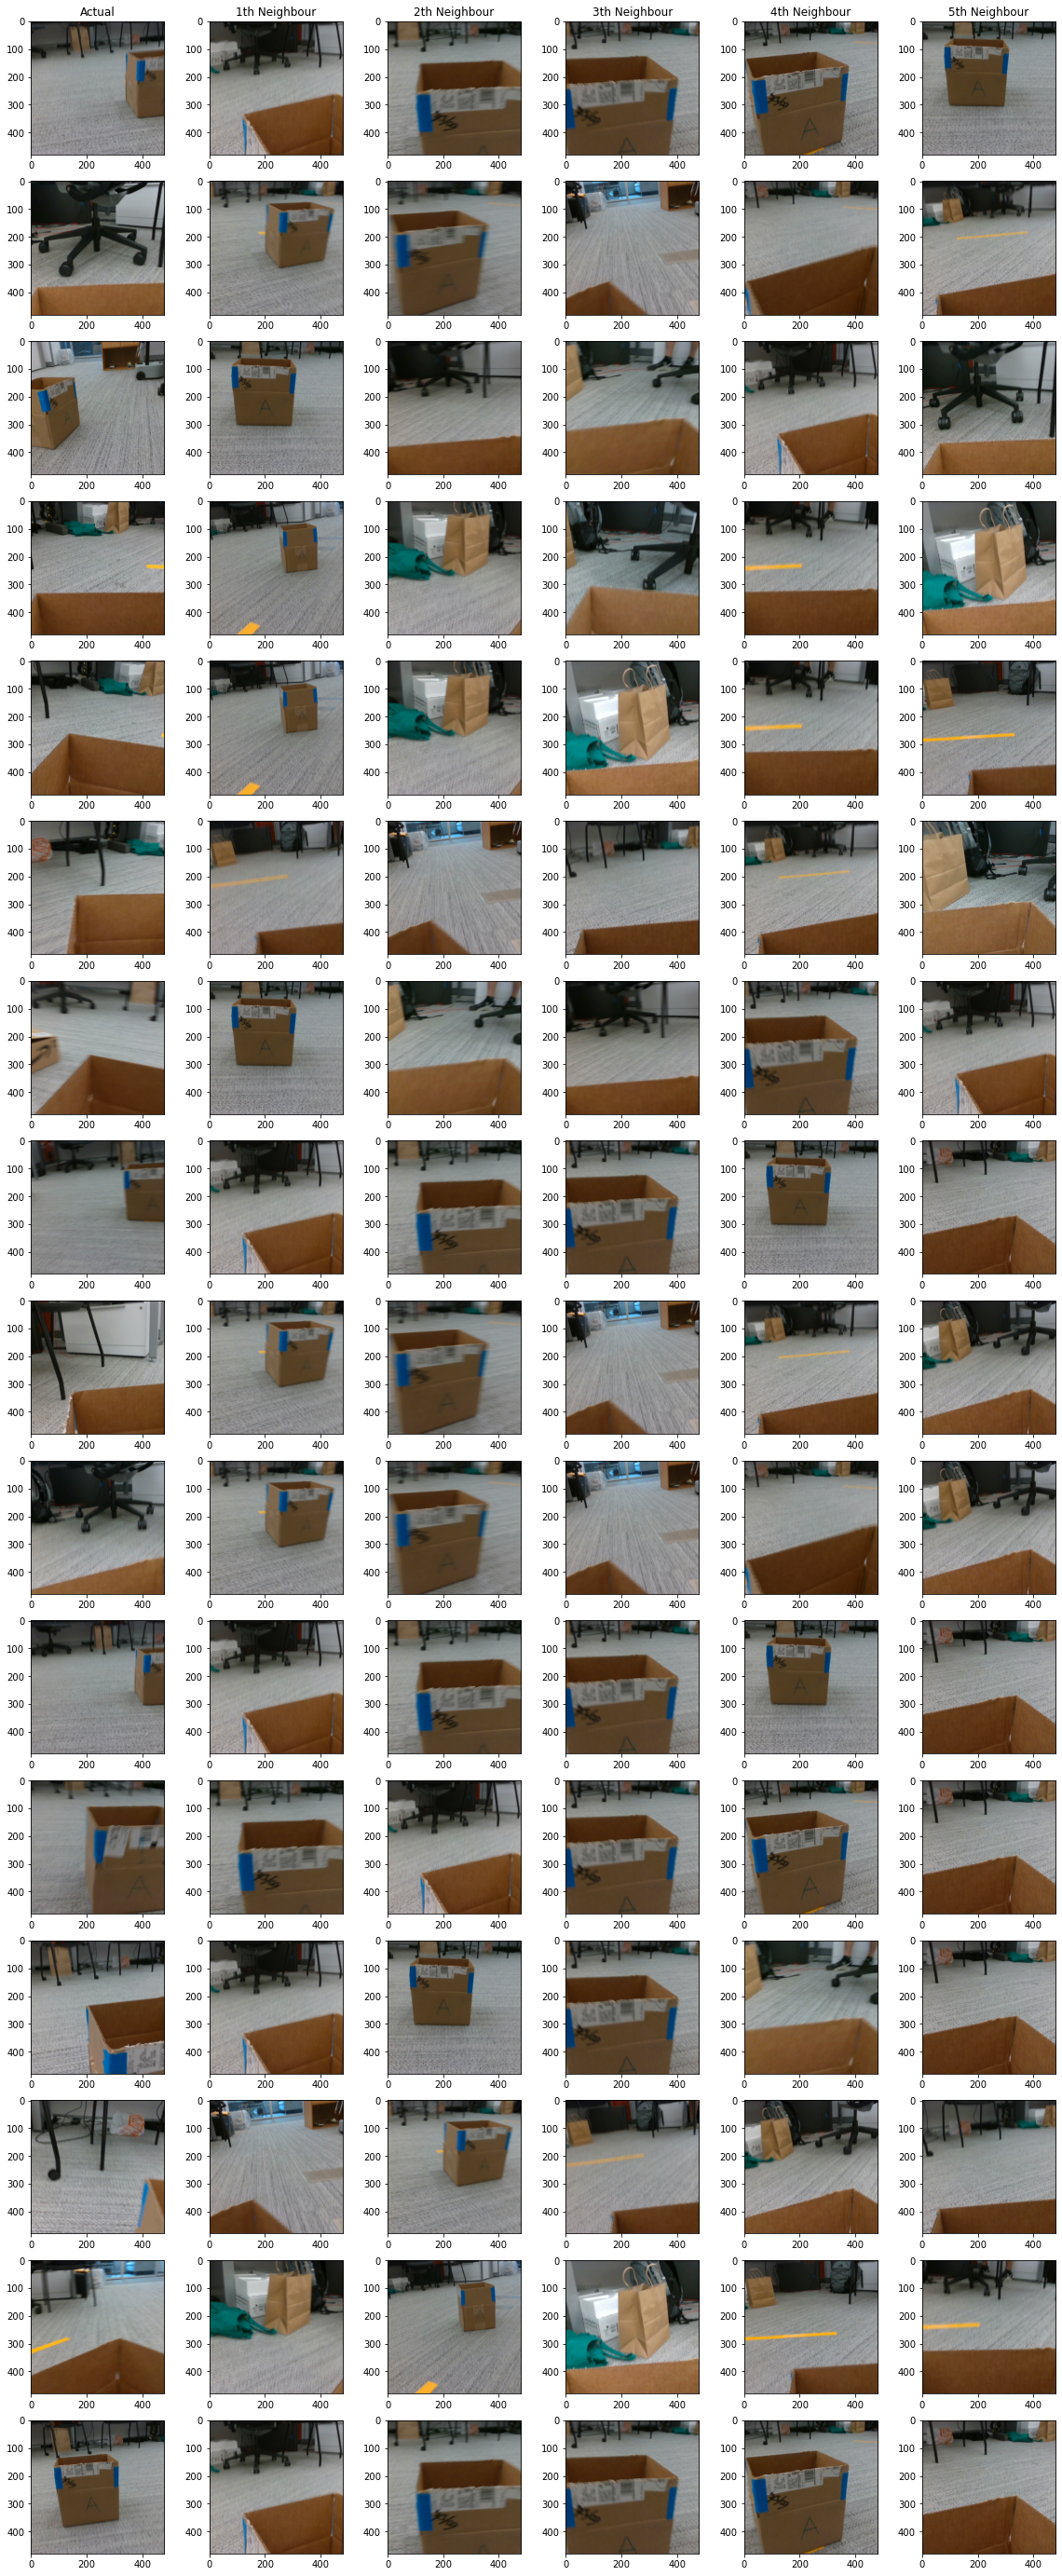

In [22]:
# Plot act_obs and test_obs
fig, axs = plt.subplots(figsize=(20,50), nrows=bs, ncols=k+1) # TODO: you can increase this as you trained more

# Name the columns
axs[0][0].set_title("Actual")
for i in range(k):
    axs[0][i+1].set_title(f"{i+1}th Neighbour")

# Save act_obs to the first column
for i in range(bs):
    axs[i][0].imshow(act_obs[i])
    # Plot the test obs
    for j in range(k):
        axs[i][j+1].imshow(test_obs[i,j])

plt.savefig(os.path.join(out_dir, 'resnet18_mlp_encoder_test.jpg'))
